In [18]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict
from IPython.display import Image

# BMI finding

In [19]:
#step 1
#Define state
class BMIState(TypedDict):
    weight_kg:float
    height_mtr:float
    bmi:float
    obese:bool


def calculate_bmi(state:BMIState) -> BMIState:
    print("State received by calculate_bmi:", state)
    weight = state["weight_kg"]
    height = state["height_mtr"]
    bmi = weight/(height**2)

    state["bmi"] = round(bmi,2)

    return state

def obese_label(state:BMIState) -> BMIState:
    bmi = state["bmi"]
    if bmi < 18.5:
        state["obese"] = False
    elif 18.5<=bmi<25:
        state["obese"] = False
    elif 25<=bmi<30:
        state["obese"] = True
    else:
        state["obese"] = False
    
    return state

    

In [20]:
#step2
#define your graph

graph=StateGraph(BMIState)

#add node
graph.add_node('calculate_bmi',calculate_bmi)
graph.add_node('is_obese',obese_label)
#add edges
graph.add_edge(START,'calculate_bmi')
graph.add_edge("calculate_bmi",'is_obese')
graph.add_edge("is_obese",END)

#compile graph
workflow = graph.compile()

#execute the graph
output_state = workflow.invoke({"weight_kg":80,"height_mtr":1.73})

print(output_state)

State received by calculate_bmi: {'weight_kg': 80, 'height_mtr': 1.73}
{'weight_kg': 80, 'height_mtr': 1.73, 'bmi': 26.73, 'obese': True}


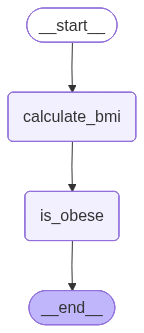

In [21]:
Image(workflow.get_graph().draw_mermaid_png())

## LLM BASED WORKFLOW

In [22]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

In [23]:
import os
load_dotenv()
groq_api_key  = os.getenv("GROQ_API_KEY")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY not found in environment")

In [24]:
llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=8192,
    api_key=groq_api_key,
    base_url = "https://api.groq.com/openai/v1"
)

In [25]:
class LLM_qa(TypedDict):
    question:str
    answer:str

In [26]:
def llm_answer(state:LLM_qa) -> LLM_qa:
    #extract questuon from state
    question = state["question"]
    #form a prompt
    prompt = f"Answer the following question {question}"
    #ask that question from LLM
    answer = llm.invoke(prompt)
    #update that in state
    state["answer"] = answer

    return state

In [27]:
graph = StateGraph(LLM_qa)

graph.add_node("llm_answer",llm_answer)

graph.add_edge(START,"llm_answer")
graph.add_edge("llm_answer",END)

workflow = graph.compile()
output_state = workflow.invoke({"question":"Why world make chatgpt, what is the core need answer shortly"})
print(output_state)

{'question': 'Why world make chatgpt, what is the core need answer shortly', 'answer': AIMessage(content='ChatGPT was created to give people easy, conversational access to powerful language‑model AI—helping with information retrieval, brainstorming, learning, and automating repetitive text tasks—so that knowledge and assistance become more instantly available to anyone who needs it.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 112, 'prompt_tokens': 89, 'total_tokens': 201, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 53, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None, 'queue_time': 0.038550111, 'prompt_time': 0.00402561, 'completion_time': 0.270576791, 'total_time': 0.274602401}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_cff00fcc7b', 'id': 'chatcmpl-2fff6286-6c1f-42ad-bd18-2dcccec431fe', 'service_tier': 'on